# Selection of articles related to migration and word frequencies exploration

* Selection of migration-related articles by filtering with key words relative frequency threshold
* Evaluation of most common words in those selected topics per quarter after normalizing with TF-IDF
    * TF-IDF maximum and minimum frequencies are optimized through Grid Search
    * We will just consider 1-grams since in this case we are not making any semantic analysis but just finding most common words

In [2]:
import sys
import nltk
import re
import os
import requests
import datetime
sys.path.append("../..")
from src.utils import google_translator, assign_quarter_labels, get_quarter_boundaries, articles_words_tokenization,\
                    articles_word_normalization, all_to_topic_articles, quantify_topic_articles_per_quarter,\
                    extract_mean_freq_words_quarter, articles_words_tokenization_annotation
from src.utils import visualize_wordcloud, distribution_filtering, get_most_freq_words_quarter, \
                    build_reverse_stemming_mapper, get_most_freq_words_quarter, text_clean_summary
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.grid_search import ParameterGrid
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse as sp_sparse
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/celsadiaz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Define text processing parameters

In [3]:
# Use the German stopwords.
stpwrds = stopwords.words("german")

# We added some additional characters to avoid.
characters = [',', '.', '(', ')', '!', ';', '-', ':', '...', '"',
                "''", "``", '~http', '?', '@', '#', '/', "'",
                '&', '--', '[', ']', '=', '||', '+', '_', '..',
                '%', '|', '~', 'http',"\n","—","•","“","„","–",
                "في","שראל","россии","не","минобороны","и","в",
                "את", "$",">","*"]

# Define key words for migration articles identification
vocabulary_target = ['einwander', 'fluchtling', 'rassismus', 'nationalismus', 'nationalsozialismus',
                     'rechtspopulismus','asyl','ertrink']
vocabulary_control = ['konsumismus', 'pflanze', 'gesundheit', 'vergewaltigt','osnabruck', 'london', 
                      'lobby', 'atomkrieg', 'lufthansa','gene', 'nordkorea', 'polizist', 'selbstmordanschlag', 
                      'rhine', 'america', 'der']

# Threshold to filter out low frequency on migration words articles
quartile = 2

# Define TF-IDF parameters for the text normalization
min_df = 20
max_df = 0.8
n_gram_min = 1
n_gram_max = 1

# Define quarter boundaries for period '12.02.2015'-'09.07.2018'
q1, q2, q3 = get_quarter_boundaries('2015')
q4, q5, q6 = get_quarter_boundaries('2016')
q7, q8, q9 = get_quarter_boundaries('2017')
q10, q11, q12 = get_quarter_boundaries('2018')
quarter_label_list = ['q1_15', 'q2_15', 'q3_15', 'q4_16', 'q5_16', 'q6_16', 'q7_17', 
                      'q8_17', 'q9_17', 'q10_18', 'q11_18']
title = ['Jan-Apr 2015', 'May-Aug 2015', 'Sep-Dec 2015', 'Jan-Apr 2016', 'May-Aug 2016', 'Sep-Dec 2016', 
         'Jan-Apr 2017', 'May-Aug 2017', 'Sep-Dec 2017', 'Jan-Apr 2018', 'May-Aug 2018']
quarter_bound_list = [q1,q2,q3,q4,q5,q6,q7,q8,q9,q10,q11]

# Define wordcloud parameters
n_top_words = 300

### Clean articles (regex + stopwords + stemming) and filter migration related ones

In [25]:
# Load and format articles dataset
articles = pd.read_csv("../../data/articles_politic_all.csv")
articles["time_line"] = [x for x in reversed(range(len(articles)))]
articles.date = articles['date'].apply(lambda x: datetime.datetime.strptime(x, "%d.%m.%Y"))

# Label articles per quarter
articles = assign_quarter_labels(articles, quarter_bound_list, quarter_label_list)

In [26]:
articles.head()

,text,date,meta_description,time_line,quarter
0,Nur wenige Stunden nach seiner eigenen Vereidi...,2018-07-09,Mit der Verfassungsänderung hat der türkische ...,32095,q11_18
1,Buddhisten und myanmarische Militärs ermordete...,2018-07-09,Wie ernst meint es die Regierung in Myanmar mi...,32094,q11_18
2,Die Nachrichten von Boris Johnsons Rücktritt m...,2018-07-09,Der Rücktritt von Brexit-Minister Davis war be...,32093,q11_18
3,Die britische Premierministerin Theresa May ha...,2018-07-09,Premierministerin Theresa May hat einen Nachfo...,32092,q11_18
4,Als früherer Journalist sollte Boris Johnson u...,2018-07-09,Der scheidende britische Außenminister Johnson...,32091,q11_18


In [27]:
# Clean summary page of the newspaper containing "DAS THEMA DES TAGES" or "DIE LAGE" or "SPIEGEL ONLINE"
articles["is_summary"] = articles["text"].apply(lambda x: text_clean_summary(x, characters))
articles = articles[articles["is_summary"] == 0]

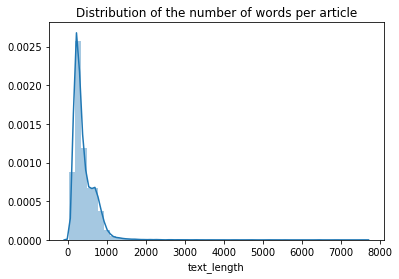

In [28]:
# Explore the distribution of number of words per article
articles['text_length'] = articles['text'].apply(lambda x: len(x.split(" ")))
_=sns.distplot(articles['text_length'])
_=plt.title("Distribution of the number of words per article")

### All articles to Migration topic selection filtering by key words frequency

In [29]:
# Calculate relative frequency of words per article after cleaning the text and removing stop words
# Normalization of frequencies over all the articles is not performed because we will get only 
# focused on key words frequencies
results = articles_words_tokenization_annotation(articles, vocabulary_target + vocabulary_control, stpwrds, 
                                                 characters)
resultsT = results.T

In [30]:
# Selection of articles that contain at least once one of the target key words related to migration
selectionT = resultsT[(resultsT["asyl"] > 0) | (resultsT["einwander"] > 0) | (resultsT["ertrink"] > 0) |\
         (resultsT["fluchtling"] > 0) | (resultsT["nationalismus"] > 0) | (resultsT["nationalsozialismus"] > 0) |\
         (resultsT["rassismus"] > 0) | (resultsT["rechtspopulismus"] > 0)].index.tolist()
selection = results.loc[:,(selectionT)]

In [31]:
print("The number of selected articles after the first filter is {} out of {}".format(len(selection.columns),
                                                                                     len(articles)))

The number of selected articles after the first filter is 5409 out of 26482


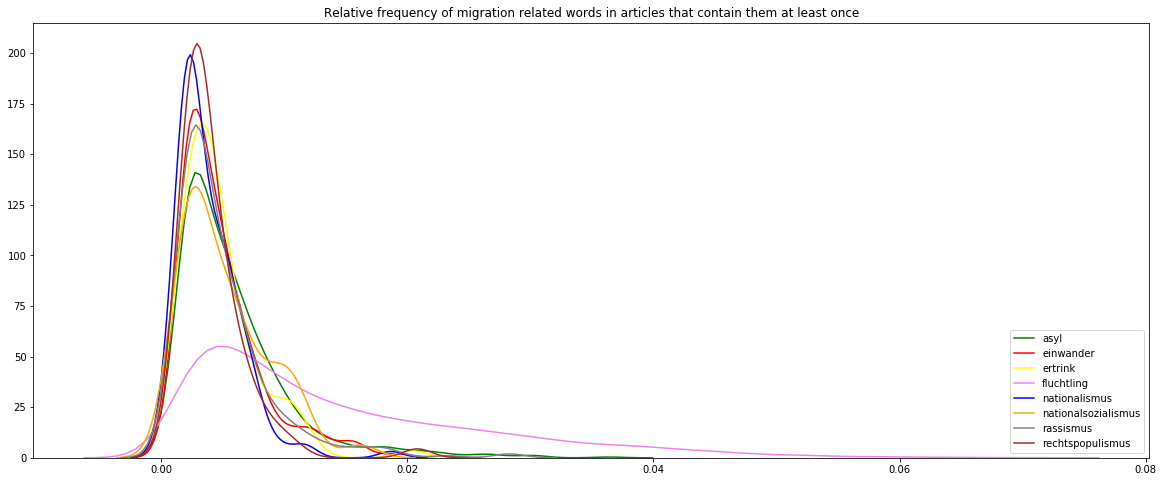

In [263]:
plt.figure(figsize=(20, 8))
sns.distplot([x for x in selection.loc["asyl"].tolist() if x > 0], hist=False, rug=False, color="green", label="asyl")
sns.distplot([x for x in selection.loc["einwander"].tolist() if x > 0], hist=False, rug=False, color="red", label="einwander")
sns.distplot([x for x in selection.loc["ertrink"].tolist() if x > 0], hist=False, rug=False, color="yellow", label="ertrink")
sns.distplot([x for x in selection.loc["fluchtling"].tolist() if x > 0], hist=False, rug=False, color="violet", label="fluchtling")
sns.distplot([x for x in selection.loc["nationalismus"].tolist() if x > 0], hist=False, rug=False, color="blue", label="nationalismus")
sns.distplot([x for x in selection.loc["nationalsozialismus"].tolist() if x > 0], hist=False, rug=False, color="orange", label="nationalsozialismus")
sns.distplot([x for x in selection.loc["rassismus"].tolist() if x > 0], hist=False, rug=False, color="gray", label="rassismus")
sns.distplot([x for x in selection.loc["rechtspopulismus"].tolist() if x > 0], hist=False, rug=False, color="brown", label="rechtspopulismus")
plt.title("Relative frequency of migration related words in articles that contain them at least once")
plt.legend(loc="lower right")

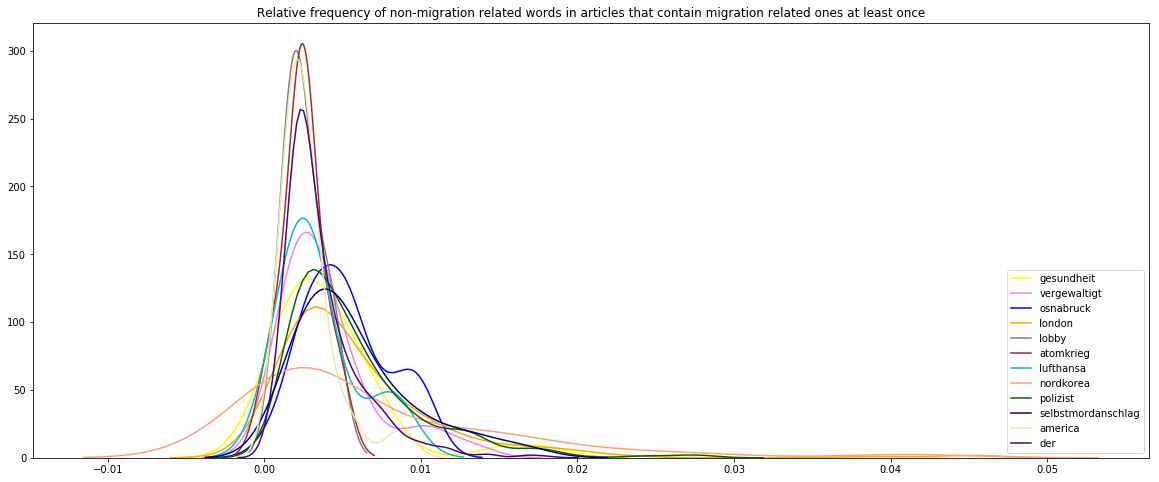

In [264]:
plt.figure(figsize=(20, 8))
sns.distplot([x for x in selection.loc["konsumismus"].tolist() if x > 0], hist=False, rug=False, color="green", label="konsumismus")
sns.distplot([x for x in selection.loc["pflanze"].tolist() if x > 0], hist=False, rug=False, color="red", label="pflanze")
sns.distplot([x for x in selection.loc["gesundheit"].tolist() if x > 0], hist=False, rug=False, color="yellow", label="gesundheit")
sns.distplot([x for x in selection.loc["vergewaltigt"].tolist() if x > 0], hist=False, rug=False, color="violet", label="vergewaltigt")
sns.distplot([x for x in selection.loc["osnabruck"].tolist() if x > 0], hist=False, rug=False, color="blue", label="osnabruck")
sns.distplot([x for x in selection.loc["london"].tolist() if x > 0], hist=False, rug=False, color="orange", label="london")
sns.distplot([x for x in selection.loc["lobby"].tolist() if x > 0], hist=False, rug=False, color="gray", label="lobby")
sns.distplot([x for x in selection.loc["atomkrieg"].tolist() if x > 0], hist=False, rug=False, color="brown", label="atomkrieg")
sns.distplot([x for x in selection.loc["lufthansa"].tolist() if x > 0], hist=False, rug=False, color="c", label="lufthansa")
sns.distplot([x for x in selection.loc["gene"].tolist() if x > 0], hist=False, rug=False, color="deeppink", label="gene")
sns.distplot([x for x in selection.loc["nordkorea"].tolist() if x > 0], hist=False, rug=False, color="lightsalmon", label="nordkorea")
sns.distplot([x for x in selection.loc["polizist"].tolist() if x > 0], hist=False, rug=False, color="darkgreen", label="polizist")
sns.distplot([x for x in selection.loc["selbstmordanschlag"].tolist() if x > 0], hist=False, rug=False, color="navy", label="selbstmordanschlag")
sns.distplot([x for x in selection.loc["rhine"].tolist() if x > 0], hist=False, rug=False, color="lime", label="rhine")
sns.distplot([x for x in selection.loc["america"].tolist() if x > 0], hist=False, rug=False, color="palegoldenrod", label="america")
sns.distplot([x for x in selection.loc["der"].tolist() if x > 0], hist=False, rug=False, color="indigo", label="der")
plt.title("Relative frequency of non-migration related words in articles that contain migration related ones at least once")
plt.legend(loc="lower right")

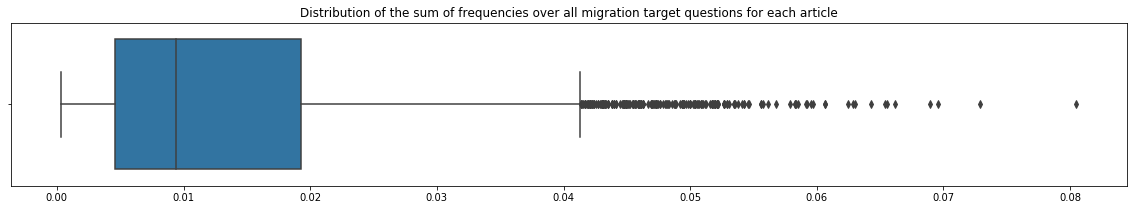

In [265]:
_=plt.figure(figsize=(20, 3))
_=sns.boxplot(selection.loc[vocabulary_target].sum(axis=0))
_=plt.title("Distribution of the sum of frequencies over all migration target questions for each article")

In [63]:
selection_complete = distribution_filtering(articles, selection, vocabulary_target, quartile)

Manual exploration shows that only those articles with a total target words frequency higher than the median (Q2) are totally focused on the topic migration.

Those articles with frequencies higher than the first quarter (Q1) contain sentences related to migration but as a side comment (i.e. US elections article where candidates mention briefly immigration as one of the main issues in the country within others). Therefore, they will not be considered.

In [267]:
selection_complete.to_csv("../../data/migration_articles.csv", index=False, encoding="utf-8")
print("We select {} articles that are mainly focused on migration-related topics.".format(len(selection_complete)))

We select 2705 articles that are mainly focused on migration-related topics.


In [4]:
selection_complete = pd.read_csv("../../data/migration_articles.csv")

### Evaluation of selected articles over time (amount and topics)

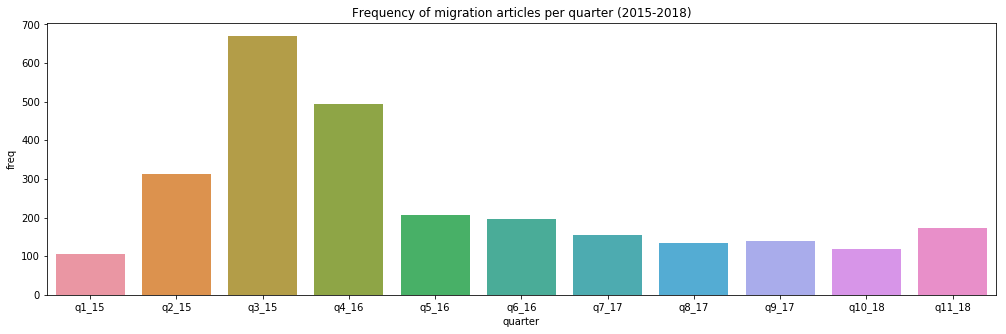

In [64]:
_=plt.figure(figsize=(17,5))
_=sns.barplot(y="freq",x="quarter",data=selection_complete.loc[:,("quarter","freq")].groupby(["quarter"], 
                                                                                    as_index=False).count(), 
            order=['q1_15', 'q2_15', 'q3_15', 'q4_16', 'q5_16', 
                   'q6_16', 'q7_17', 'q8_17', 'q9_17', 'q10_18', 'q11_18'])
_=plt.title("Frequency of migration articles per quarter (2015-2018)")

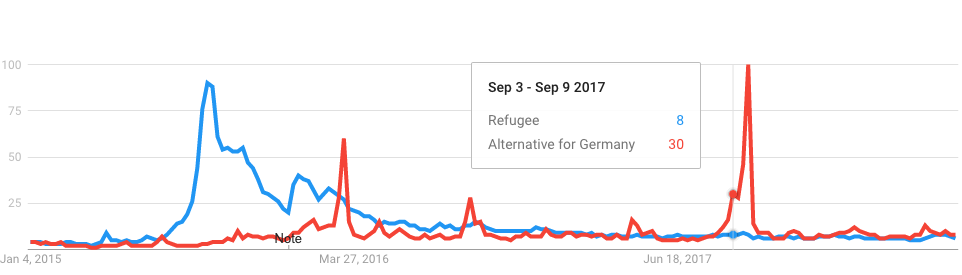

In [269]:
from IPython.display import Image
Image("../../img/refugee_afd_evolution.png")

We see the highest pick on number of topic related articles with the european refugee crisis in 2015.

A second wave comes with the pick observed for AfD in Google Treds picture. It could be related with the US elections and the rise of national socialism in US, France and Germany after the refugee crisis. There is a clear effect on the number of related articles in the last quarter of 2016.

It is not until the german national elections that we see again a pick on the amount of articles related to migration. It is in the same period than the huge pick of AfD searches in Google Treds.

Finally, we see a new growth on the number of articles in the most recent quarter, likely due to the current crisis in the Mediterranean See and the rejection of Italy and Malta to open their ports to the rescued refugees.

### Grid search the best parameters for word count normalization (TF-IDF)

In [5]:
articles_tokenized = articles_words_tokenization(selection_complete, stpwrds, characters)

In [6]:
articles_tokenized = articles_tokenized.drop(["article_id","text_length"], axis=1)

In [17]:
param_grid = {"min_df": [10, 30, 40, 50, 60, 80, 100, 200],
                "max_df": [0.5, 0.6, 0.7, 0.8, 0.9]}
grid = ParameterGrid(param_grid)

In [18]:
results_grid_search = []
for params in grid:
    try:
        results_grid = {}
        # from selected articles calculate normalized frequencies of words
        results_topic, resultsT_topic = articles_word_normalization(articles_tokenized, params["min_df"], 
                                                                    params["max_df"],n_gram_min, n_gram_max)
    
        # calculate metrics of selected words frequencies per quarter for the selected topic articles
        freqs_quarter, metrics = extract_mean_freq_words_quarter(resultsT_topic, articles_tokenized, 
                                                                 vocabulary_target, vocabulary_control)
        results_grid["min_df"] = params["min_df"]
        results_grid["max_df"] = params["max_df"]
        results_grid["freqs_quarter"] = freqs_quarter
        results_grid["metrics"] = metrics
        results_grid_search.append(results_grid)
    except:
        print("Combination of parameters min_df: {}, max_df: {} do not work."\
              .format(params['min_df'], params['max_df']))

Results have 2705 articles and 5642 normalized words
The frequencies for words: ['rechtspopulismus', 'nationalsozialismus', 'ertrink', 'rassismus', 'asyl', 'einwander', 'nationalismus']
is: [0.018125192186697503, 0.00452211276081892, 0.004354728521428145, 0.0020535893657263344, 0.0013692464213850976, 0.00042177691041306591, 0.00036863269480438843]
The sum of the frequencies is: 0.031215278861273458
The frequencies for control words: ['london', 'gesundheit', 'vergewaltigt', 'polizist', 'selbstmordanschlag', 'der', 'osnabruck']
is: [0.0085317792996332208, 0.0029139313849512621, 0.0023236229403609089, 0.00091843156008053603, 0.0, 0.0, 0.0]
The sum of the frequencies is: 0.014687765185025929
The frequencies for words: ['rechtspopulismus', 'nationalsozialismus', 'nationalismus', 'rassismus', 'asyl', 'ertrink', 'einwander']
is: [0.016729149686380482, 0.0037155473604887222, 0.0030702551074745115, 0.0020932707017994883, 0.00048488061773860932, 0.00041794899275294421, 0.0]
The sum of the freque

The frequencies for words: ['rassismus', 'einwander', 'asyl', 'ertrink']
is: [0.0045820733425991156, 0.0020273831297758856, 0.0014703771245306203, 0.0010391704038307168]
The sum of the frequencies is: 0.009119004000736338
The frequencies for control words: ['der', 'london', 'polizist']
is: [0.0062079931688487425, 0.0038838644886259777, 0.0015450630713751113]
The sum of the frequencies is: 0.011636920728849831
The frequencies for words: ['einwander', 'rassismus', 'ertrink', 'asyl']
is: [0.0038552988495379643, 0.0025102949404935048, 0.0016370637256653588, 0.0015135193295684535]
The sum of the frequencies is: 0.009516176845265283
The frequencies for control words: ['der', 'london', 'polizist']
is: [0.0043808729460316576, 0.0024955921050565351, 0.0012116868623094463]
The sum of the frequencies is: 0.008088151913397639
The frequencies for words: ['rassismus', 'einwander', 'ertrink', 'asyl']
is: [0.0032224650080655902, 0.0025711106971113523, 0.0025175398533126125, 0.0011753624214598543]
The 

The frequencies for words: ['rassismus', 'asyl', 'ertrink', 'einwander']
is: [0.0064139261554565048, 0.0060475372567836572, 0.0032618223907095543, 0.0020669883471056139]
The sum of the frequencies is: 0.01779027415005533
The frequencies for control words: ['london', 'polizist', 'der']
is: [0.0083162330300780313, 0.004553865834858283, 0.00031742979590272289]
The sum of the frequencies is: 0.013187528660839037
The frequencies for words: ['rassismus', 'asyl', 'ertrink', 'einwander']
is: [0.0061479000657686756, 0.0060635143807205565, 0.00098820755100805283, 0.00082435129476584918]
The sum of the frequencies is: 0.014023973292263134
The frequencies for control words: ['london', 'der', 'polizist']
is: [0.0087357345254374559, 0.0035592393595421253, 0.0034978264110067125]
The sum of the frequencies is: 0.015792800295986294
The frequencies for words: ['asyl', 'rassismus', 'einwander', 'ertrink']
is: [0.0070889843519523748, 0.0035746713007555595, 0.0018385608490225447, 0.00091219642500420912]
Th

Results have 2705 articles and 1116 normalized words
The frequencies for words: ['einwander', 'rassismus', 'asyl']
is: [0.0089873204440627952, 0.0021141498669347658, 0.00084817314492705899]
The sum of the frequencies is: 0.01194964345592462
The frequencies for control words: ['polizist', 'der']
is: [0.0031786770216454506, 0.001413482533879656]
The sum of the frequencies is: 0.004592159555525107
The frequencies for words: ['einwander', 'rassismus', 'asyl']
is: [0.019509511826507404, 0.0058090750792774096, 0.004239651954478685]
The sum of the frequencies is: 0.029558238860263496
The frequencies for control words: ['polizist', 'der']
is: [0.0072831845038741445, 0.0026306747172305705]
The sum of the frequencies is: 0.009913859221104715
The frequencies for words: ['einwander', 'asyl', 'rassismus']
is: [0.0071398708199258603, 0.0051410874552207282, 0.0023823426269739515]
The sum of the frequencies is: 0.014663300902120539
The frequencies for control words: ['der', 'polizist']
is: [0.00360912

The frequencies for words: ['asyl']
is: [0.019470120273912594]
The sum of the frequencies is: 0.019470120273912594
The frequencies for control words: ['polizist', 'der']
is: [0.016971145220888707, 0.01393635920020476]
The sum of the frequencies is: 0.030907504421093468
The frequencies for words: ['asyl']
is: [0.022509701422018562]
The sum of the frequencies is: 0.022509701422018562
The frequencies for control words: ['polizist', 'der']
is: [0.018010810816859738, 0.012875103437851622]
The sum of the frequencies is: 0.03088591425471136
The frequencies for words: ['asyl']
is: [0.021466217552959611]
The sum of the frequencies is: 0.02146621755295961
The frequencies for control words: ['polizist', 'der']
is: [0.020948694932399925, 0.016291075500245517]
The sum of the frequencies is: 0.03723977043264544
The frequencies for words: ['asyl']
is: [0.0131953273897667]
The sum of the frequencies is: 0.0131953273897667
The frequencies for control words: ['polizist', 'der']
is: [0.027614739767791274

The frequencies for words: ['rechtspopulismus', 'rassismus', 'ertrink', 'asyl', 'nationalismus', 'einwander', 'nationalsozialismus']
is: [0.0087228028160939372, 0.002023516265782069, 0.001039570450265133, 0.00056612048760427253, 0.00046363221805773101, 0.0, 0.0]
The sum of the frequencies is: 0.012815642237803144
The frequencies for control words: ['vergewaltigt', 'selbstmordanschlag', 'polizist', 'gesundheit', 'london', 'der', 'osnabruck']
is: [0.0017624530912532267, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
The sum of the frequencies is: 0.0017624530912532267
Results have 2705 articles and 2582 normalized words
The frequencies for words: ['rassismus', 'einwander', 'ertrink', 'asyl']
is: [0.018159385482314546, 0.0091912926632803562, 0.0037433268592485065, 0.0020998413801508764]
The sum of the frequencies is: 0.033193846384994286
The frequencies for control words: ['polizist', 'der', 'london']
is: [0.0066552850588532378, 0.0, 0.0]
The sum of the frequencies is: 0.006655285058853238
The frequencies

The frequencies for words: ['ertrink', 'rassismus', 'asyl', 'einwander']
is: [0.0097236698944198757, 0.0068369407476026323, 0.0043119248290447686, 0.0030595510099496472]
The sum of the frequencies is: 0.023932086481016922
The frequencies for control words: ['der', 'london', 'polizist']
is: [0.0035176305016245669, 0.00064205646780668879, 0.0]
The sum of the frequencies is: 0.004159686969431256
The frequencies for words: ['ertrink', 'rassismus', 'asyl', 'einwander']
is: [0.013499777924685203, 0.0016441270525380655, 0.00094066485190641262, 0.00037186751627977881]
The sum of the frequencies is: 0.01645643734540946
The frequencies for control words: ['der', 'london', 'polizist']
is: [0.0012906076846576238, 0.00051018324639114793, 0.0]
The sum of the frequencies is: 0.0018007909310487717
The frequencies for words: ['ertrink', 'asyl', 'rassismus', 'einwander']
is: [0.010642100502778614, 0.006195160202245034, 0.0053736232101637953, 0.00031287412924865305]
The sum of the frequencies is: 0.02252

The frequencies for words: ['einwander', 'asyl', 'rassismus', 'ertrink']
is: [0.0057533139742950313, 0.0042743319661982127, 0.0025209751155516485, 0.0020587603024852827]
The sum of the frequencies is: 0.014607381358530175
The frequencies for control words: ['der', 'polizist']
is: [0.0050897131223115151, 0.0029658378165256754]
The sum of the frequencies is: 0.00805555093883719
The frequencies for words: ['einwander', 'ertrink', 'asyl', 'rassismus']
is: [0.0030107639155744033, 0.0022908260890252261, 0.0018476695761497708, 0.0]
The sum of the frequencies is: 0.007149259580749401
The frequencies for control words: ['polizist', 'der']
is: [0.0013599687636911308, 0.0011632238544766488]
The sum of the frequencies is: 0.0025231926181677796
The frequencies for words: ['ertrink', 'rassismus', 'einwander', 'asyl']
is: [0.0035970147624168288, 0.001399509975140322, 0.00077228896663729374, 0.0004878828675087573]
The sum of the frequencies is: 0.006256696571703202
The frequencies for control words: [

The frequencies for words: ['rassismus', 'asyl', 'einwander']
is: [0.0054396713318566776, 0.0040753853854264164, 0.0023511266908293419]
The sum of the frequencies is: 0.011866183408112437
The frequencies for control words: ['der', 'polizist']
is: [0.011275646676028555, 0.0029671051603324503]
The sum of the frequencies is: 0.014242751836361004
The frequencies for words: ['asyl', 'einwander', 'rassismus']
is: [0.013674357433016126, 0.0037381723688826251, 0.0034205306499976314]
The sum of the frequencies is: 0.020833060451896382
The frequencies for control words: ['der', 'polizist']
is: [0.046009505989514171, 0.0029866027247695249]
The sum of the frequencies is: 0.0489961087142837
Results have 2705 articles and 416 normalized words
The frequencies for words: ['asyl']
is: [0.010759828938712631]
The sum of the frequencies is: 0.010759828938712631
The frequencies for control words: ['polizist', 'der']
is: [0.030901411806325919, 0.021042937114117092]
The sum of the frequencies is: 0.051944348

The frequencies for words: ['rechtspopulismus', 'asyl', 'rassismus', 'nationalsozialismus', 'einwander', 'nationalismus', 'ertrink']
is: [0.014595935459602936, 0.0082844192024545942, 0.0022641923419615727, 0.0013888392953249524, 0.00042825745100235924, 0.0, 0.0]
The sum of the frequencies is: 0.026961643750346414
The frequencies for control words: ['vergewaltigt', 'polizist', 'london', 'selbstmordanschlag', 'osnabruck', 'der', 'gesundheit']
is: [0.0011955792857156627, 0.00086756215372289737, 0.00072917707269973459, 0.0, 0.0, 0.0, 0.0]
The sum of the frequencies is: 0.0027923185121382947
The frequencies for words: ['rechtspopulismus', 'asyl', 'ertrink', 'rassismus', 'einwander', 'nationalismus', 'nationalsozialismus']
is: [0.017401566505967525, 0.0075961303523138912, 0.0043555840007803411, 0.0036409903214661412, 0.0016937855171335178, 0.00099219497753517288, 0.0]
The sum of the frequencies is: 0.03568025167519659
The frequencies for control words: ['polizist', 'london', 'vergewaltigt', 

The frequencies for words: ['ertrink', 'rassismus', 'einwander', 'asyl']
is: [0.022748107371544053, 0.0040715630634478141, 0.0024570026257831196, 0.0021143354894751225]
The sum of the frequencies is: 0.03139100855025011
The frequencies for control words: ['der', 'polizist', 'london']
is: [0.012163332091380237, 0.0053174970656463616, 0.0026802894734707147]
The sum of the frequencies is: 0.020161118630497313
The frequencies for words: ['ertrink', 'rassismus', 'asyl', 'einwander']
is: [0.026951532902407337, 0.006964287416876074, 0.0020138821634427899, 0.0017319721787908719]
The sum of the frequencies is: 0.03766167466151707
The frequencies for control words: ['polizist', 'der', 'london']
is: [0.018596818874725359, 0.011372101925707092, 0.0015003603752727611]
The sum of the frequencies is: 0.031469281175705216
The frequencies for words: ['ertrink', 'rassismus', 'asyl', 'einwander']
is: [0.0071779842703916337, 0.0045938249009869515, 0.0019627166374349891, 0.00082513073435931358]
The sum of 

The frequencies for words: ['ertrink', 'asyl', 'einwander', 'rassismus']
is: [0.02124419368516926, 0.0060510728250535821, 0.0018300971552484642, 0.00058685981455761408]
The sum of the frequencies is: 0.02971222348002892
The frequencies for control words: ['der', 'polizist']
is: [0.0089516780080862359, 0.0064874233030149308]
The sum of the frequencies is: 0.015439101311101166
The frequencies for words: ['ertrink', 'einwander', 'asyl', 'rassismus']
is: [0.013678968038638382, 0.0057200164797311008, 0.0024413915057909896, 0.0011275383926350419]
The sum of the frequencies is: 0.022967914416795517
The frequencies for control words: ['der', 'polizist']
is: [0.0063369009125430076, 0.0035782098676604523]
The sum of the frequencies is: 0.00991511078020346
The frequencies for words: ['asyl', 'ertrink', 'rassismus', 'einwander']
is: [0.0080421497792324912, 0.0071572191563549726, 0.0032039545897103571, 0.0027872410634595746]
The sum of the frequencies is: 0.021190564588757392
The frequencies for co

The frequencies for words: ['rassismus', 'asyl', 'einwander']
is: [0.011088773579318046, 0.005643743639182291, 0.00064964940332673863]
The sum of the frequencies is: 0.017382166621827077
The frequencies for control words: ['der', 'polizist']
is: [0.0087110393302218848, 0.0038719047414949512]
The sum of the frequencies is: 0.012582944071716836
The frequencies for words: ['rassismus', 'asyl', 'einwander']
is: [0.0099595537368589327, 0.0063812313168835231, 0.0056461530593918449]
The sum of the frequencies is: 0.021986938113134298
The frequencies for control words: ['der', 'polizist']
is: [0.0086433055292975021, 0.0058429211348664453]
The sum of the frequencies is: 0.014486226664163947
The frequencies for words: ['einwander', 'rassismus', 'asyl']
is: [0.016332699087790316, 0.0060148638643229497, 0.0053529389960288928]
The sum of the frequencies is: 0.027700501948142157
The frequencies for control words: ['der', 'polizist']
is: [0.0081120002967914363, 0.0071438323971828397]
The sum of the f

The frequencies for words: ['rechtspopulismus', 'ertrink', 'rassismus', 'nationalsozialismus', 'einwander', 'nationalismus', 'asyl']
is: [0.0097766559985750477, 0.0071578291310236582, 0.0025132679613386359, 0.0015689475721256726, 0.00098413007315614623, 0.0009796528111941183, 9.686481741611277e-05]
The sum of the frequencies is: 0.023077348364829393
The frequencies for control words: ['osnabruck', 'london', 'selbstmordanschlag', 'der', 'gesundheit', 'vergewaltigt', 'polizist']
is: [0.0042050473417399427, 0.0036370549096283802, 0.00082807403767299378, 0.00063857951090674596, 0.00054100243963124857, 0.00034397439638212795, 0.00013743540087098977]
The sum of the frequencies is: 0.010331168036832426
The frequencies for words: ['rechtspopulismus', 'ertrink', 'rassismus', 'nationalismus', 'nationalsozialismus', 'einwander', 'asyl']
is: [0.0094277943104375955, 0.0042713227307090117, 0.0018373068186162557, 0.0012169769617400908, 0.00097622708169126148, 0.0007746644108243408, 0.0004532539581295

The frequencies for words: ['rassismus', 'einwander', 'ertrink', 'asyl']
is: [0.0085834539600231404, 0.0083141532653941645, 0.0064904938871439954, 0.0032174930258910155]
The sum of the frequencies is: 0.02660559413845232
The frequencies for control words: ['polizist', 'london', 'der']
is: [0.00092684115888121458, 0.0004720242259504062, 0.0]
The sum of the frequencies is: 0.0013988653848316208
The frequencies for words: ['einwander', 'ertrink', 'rassismus', 'asyl']
is: [0.011916335332693838, 0.0057830123713950993, 0.0048454246644651219, 0.0040678209515304696]
The sum of the frequencies is: 0.02661259332008453
The frequencies for control words: ['london', 'polizist', 'der']
is: [0.0092158252266715691, 0.0031974199556038295, 0.0024887952390497381]
The sum of the frequencies is: 0.014902040421325138
Results have 2705 articles and 2071 normalized words
The frequencies for words: ['ertrink', 'rassismus', 'asyl', 'einwander']
is: [0.03231181466704653, 0.0038632568584653711, 0.0014395296763634

The frequencies for words: ['einwander', 'ertrink', 'rassismus', 'asyl']
is: [0.020907793912595351, 0.0026020526162253677, 0.0024765633017842232, 0.0014258118285198618]
The sum of the frequencies is: 0.027412221659124804
The frequencies for control words: ['london', 'der', 'polizist']
is: [0.0069240585792009895, 0.0039982514025089207, 0.0021159988415792824]
The sum of the frequencies is: 0.013038308823289192
The frequencies for words: ['einwander', 'asyl', 'ertrink', 'rassismus']
is: [0.017113665748624805, 0.0026711645360486262, 0.0020349411325258121, 0.0013123666744548909]
The sum of the frequencies is: 0.023132138091654132
The frequencies for control words: ['london', 'polizist', 'der']
is: [0.0063826542939639502, 0.003543906743903028, 0.0027352669024876745]
The sum of the frequencies is: 0.012661827940354652
The frequencies for words: ['einwander', 'rassismus', 'ertrink', 'asyl']
is: [0.0182503631108747, 0.0037319569313825503, 0.0016449602618283207, 0.0]
The sum of the frequencies i

The frequencies for words: ['rassismus', 'einwander', 'asyl']
is: [0.012586859080488771, 0.010873860732443393, 0.0023302064676405032]
The sum of the frequencies is: 0.025790926280572668
The frequencies for control words: ['der', 'polizist']
is: [0.0047285859421277538, 0.0036156889752773699]
The sum of the frequencies is: 0.008344274917405123
The frequencies for words: ['rassismus', 'einwander', 'asyl']
is: [0.013275782352695532, 0.0059051622708858713, 0.0023924882525888074]
The sum of the frequencies is: 0.02157343287617021
The frequencies for control words: ['polizist', 'der']
is: [0.0027098002744067235, 0.0013311829891764864]
The sum of the frequencies is: 0.00404098326358321
The frequencies for words: ['rassismus', 'einwander', 'asyl']
is: [0.010438602324626511, 0.0071589548839210313, 0.00066140999307301321]
The sum of the frequencies is: 0.018258967201620558
The frequencies for control words: ['polizist', 'der']
is: [0.0054623841644505901, 0.0025982927869143144]
The sum of the freq

Results have 2705 articles and 5650 normalized words
The frequencies for words: ['rechtspopulismus', 'rassismus', 'ertrink', 'nationalsozialismus', 'einwander', 'asyl', 'nationalismus']
is: [0.017995850175600129, 0.0049836238031626288, 0.0035574236346945769, 0.0018697409968318195, 0.00090475926499557398, 0.0, 0.0]
The sum of the frequencies is: 0.029311397875284733
The frequencies for control words: ['london', 'der', 'polizist', 'selbstmordanschlag', 'gesundheit', 'osnabruck', 'vergewaltigt']
is: [0.0055465044208897621, 0.00092446582130184399, 0.00086640191723955703, 0.0, 0.0, 0.0, 0.0]
The sum of the frequencies is: 0.007337372159431164
The frequencies for words: ['rechtspopulismus', 'ertrink', 'rassismus', 'nationalismus', 'nationalsozialismus', 'einwander', 'asyl']
is: [0.016609984146995986, 0.0035152841514453389, 0.0014469224126516451, 0.0012159277582166404, 0.00080864200439263777, 0.0, 0.0]
The sum of the frequencies is: 0.02359676047370225
The frequencies for control words: ['lon

The frequencies for words: ['ertrink', 'einwander', 'rassismus', 'asyl']
is: [0.0078265760282375668, 0.0070191484846666864, 0.0042771453017490793, 0.0015440660858439517]
The sum of the frequencies is: 0.020666935900497282
The frequencies for control words: ['der', 'polizist', 'london']
is: [0.012744053784992384, 0.0020456353120400336, 0.0011215528181851349]
The sum of the frequencies is: 0.01591124191521755
The frequencies for words: ['ertrink', 'einwander', 'rassismus', 'asyl']
is: [0.0084816594477322479, 0.0076713551338464204, 0.0033112058395293447, 0.0026247714841319244]
The sum of the frequencies is: 0.022088991905239937
The frequencies for control words: ['london', 'der', 'polizist']
is: [0.0051726169928603951, 0.0039217558280911302, 0.0027982587846868199]
The sum of the frequencies is: 0.011892631605638346
The frequencies for words: ['einwander', 'ertrink', 'rassismus', 'asyl']
is: [0.011433705519727867, 0.0044139752963015672, 0.0020694178084815188, 0.0015715388320687068]
The sum

The frequencies for words: ['einwander', 'ertrink', 'asyl', 'rassismus']
is: [0.013433151835367021, 0.0032381029623979067, 0.0021839128897093714, 0.0013049648253843666]
The sum of the frequencies is: 0.020160132512858666
The frequencies for control words: ['london', 'der', 'polizist']
is: [0.0054880121412081402, 0.0045645967907449302, 0.0021725533287275849]
The sum of the frequencies is: 0.012225162260680655
The frequencies for words: ['einwander', 'asyl', 'rassismus', 'ertrink']
is: [0.017333246981631471, 0.0022791338826423195, 0.0015086883607017291, 0.00097392697007283539]
The sum of the frequencies is: 0.022094996195048355
The frequencies for control words: ['der', 'london', 'polizist']
is: [0.0028548157925119264, 0.0017717612778812759, 0.0015345624577964882]
The sum of the frequencies is: 0.00616113952818969
The frequencies for words: ['einwander', 'rassismus', 'asyl', 'ertrink']
is: [0.024479668672161208, 0.0042955565658483246, 0.0011593762641624926, 0.00090161883739995805]
The su

Results have 2705 articles and 1124 normalized words
The frequencies for words: ['rassismus', 'asyl', 'einwander']
is: [0.011681275561109638, 0.0043285188722264473, 0.0029787459344186194]
The sum of the frequencies is: 0.018988540367754703
The frequencies for control words: ['der', 'polizist']
is: [0.0025703401754089174, 0.00043515134028209221]
The sum of the frequencies is: 0.0030054915156910098
The frequencies for words: ['rassismus', 'einwander', 'asyl']
is: [0.014084784446489293, 0.0015235040420186765, 0.0010668593201079259]
The sum of the frequencies is: 0.016675147808615894
The frequencies for control words: ['der', 'polizist']
is: [0.0033450655148241316, 0.00176878073165978]
The sum of the frequencies is: 0.005113846246483911
The frequencies for words: ['asyl', 'einwander', 'rassismus']
is: [0.011724240350729791, 0.0067693924426821392, 0.0055322446479991556]
The sum of the frequencies is: 0.024025877441411086
The frequencies for control words: ['der', 'polizist']
is: [0.00681847

The frequencies for words: ['asyl']
is: [0.019545321320791124]
The sum of the frequencies is: 0.019545321320791124
The frequencies for control words: ['der', 'polizist']
is: [0.026609770118147812, 0.016520732125332904]
The sum of the frequencies is: 0.043130502243480716
The frequencies for words: ['asyl']
is: [0.017354669513561988]
The sum of the frequencies is: 0.017354669513561988
The frequencies for control words: ['der', 'polizist']
is: [0.021720430256418708, 0.017446053320719804]
The sum of the frequencies is: 0.03916648357713851
The frequencies for words: ['asyl']
is: [0.016264400077455731]
The sum of the frequencies is: 0.01626440007745573
The frequencies for control words: ['der', 'polizist']
is: [0.027088517804841446, 0.020256248809331079]
The sum of the frequencies is: 0.04734476661417253
The frequencies for words: ['asyl']
is: [0.021747367399494646]
The sum of the frequencies is: 0.021747367399494646
The frequencies for control words: ['der', 'polizist']
is: [0.0281587839563

In [19]:
# shape grid search results
results_gs = []
for i in range(len(results_grid_search)):
    df = pd.DataFrame.from_records(results_grid_search[i]["metrics"]).mean()
    df["max_df"] = results_grid_search[i]["max_df"]
    df["min_df"] = results_grid_search[i]["min_df"]
    results_gs.append(df)
df_results_gs = pd.concat(results_gs, axis=1).T
df_results_gs["diff_freqs"] = df_results_gs["total_freqs"] - df_results_gs["total_freqs_c"]

In [22]:
# Choose the parameters for a highest freq on target words and a highest difference between
# freq of target words and control ones
df_results_gs = df_results_gs.sort_values(by=["total_freqs"])
df_results_gs.to_csv("../../data/tf-idf_gs_results.csv", index=False, encoding='utf-8')
df_results_gs.tail(10)

,control_perc,target_perc,total_freqs,total_freqs_c,max_df_2,min_df_2,diff_freqs
26,18.75,50.0,0.024848,0.010663,0.8,40.0,0.014185
14,12.50,37.5,0.025132,0.017966,0.6,100.0,0.007166
18,18.75,50.0,0.025636,0.021191,0.7,40.0,0.004445
10,18.75,50.0,0.026032,0.004831,0.6,40.0,0.021202
2,18.75,50.0,0.026235,0.010976,0.5,40.0,0.015259
23,12.50,12.5,0.028735,0.039136,0.7,200.0,-0.010402
4,12.50,50.0,0.029865,0.033603,0.5,60.0,-0.003738
6,12.50,37.5,0.030836,0.018056,0.5,100.0,0.012780
30,12.50,37.5,0.040575,0.008797,0.8,100.0,0.031778
38,12.50,37.5,0.040575,0.008797,0.9,100.0,0.031778


The combination of parameters that results in a most clear wordcloud representation is that one that obtain:
* High difference between percentage of appearance on key words against control words
* High difference between sum of frequencies of key words against control words
* High percentage of appearance on key words
* High sum of frequencies of key words

#### Run word normalization with best parameters and extract most common words per quarter

In [7]:
min_df = 10
max_df = 0.9

In [8]:
# from selected articles calculate normalized frequencies of words
results_topic, resultsT_topic = articles_word_normalization(articles_tokenized, min_df, 
                                                            max_df,n_gram_min, n_gram_max)
    
# calculate metrics of selected words frequencies per quarter for the selected topic articles
freqs_quarter, metrics = extract_mean_freq_words_quarter(resultsT_topic, articles_tokenized, 
                                                        vocabulary_target, vocabulary_control)

Results have 2705 articles and 5650 normalized words
The frequencies for words: ['rechtspopulismus', 'rassismus', 'ertrink', 'nationalsozialismus', 'einwander', 'asyl', 'nationalismus']
is: [0.017995850175600129, 0.0049836238031626288, 0.0035574236346945769, 0.0018697409968318195, 0.00090475926499557398, 0.0, 0.0]
The sum of the frequencies is: 0.029311397875284733
The frequencies for control words: ['london', 'der', 'polizist', 'selbstmordanschlag', 'gesundheit', 'osnabruck', 'vergewaltigt']
is: [0.0055465044208897621, 0.00092446582130184399, 0.00086640191723955703, 0.0, 0.0, 0.0, 0.0]
The sum of the frequencies is: 0.007337372159431164
The frequencies for words: ['rechtspopulismus', 'ertrink', 'rassismus', 'nationalismus', 'nationalsozialismus', 'einwander', 'asyl']
is: [0.016609984146995986, 0.0035152841514453389, 0.0014469224126516451, 0.0012159277582166404, 0.00080864200439263777, 0.0, 0.0]
The sum of the frequencies is: 0.02359676047370225
The frequencies for control words: ['lon

### Visualization of most common words per quarter by reverse stemming

In [9]:
stemming_mapper = build_reverse_stemming_mapper(selection_complete, characters, stpwrds)

In [10]:
dict_freqs_quarter = get_most_freq_words_quarter(freqs_quarter, n_top_words, stemming_mapper)

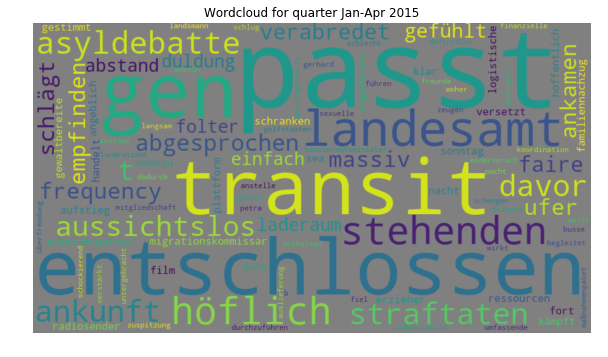

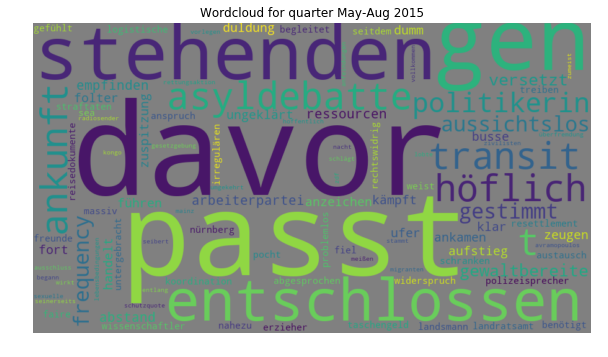

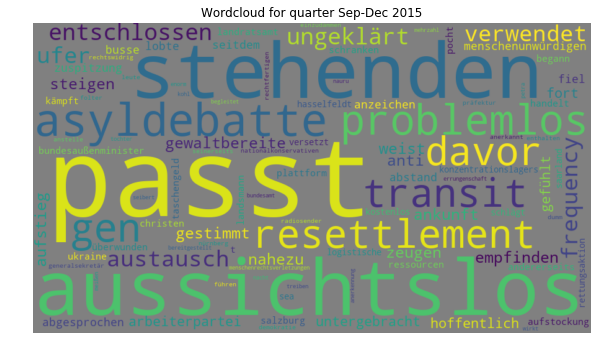

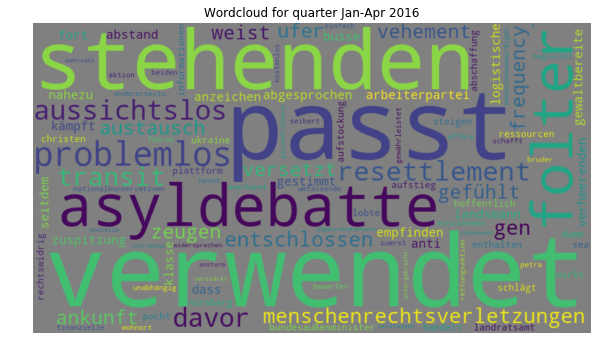

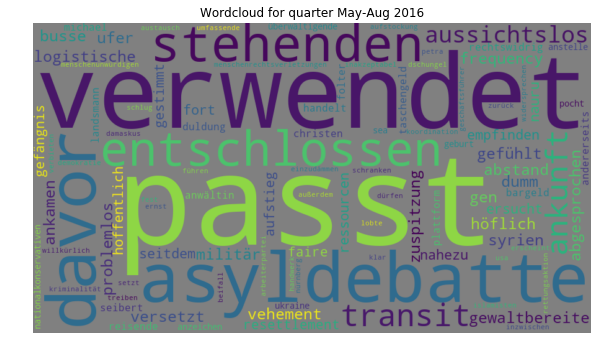

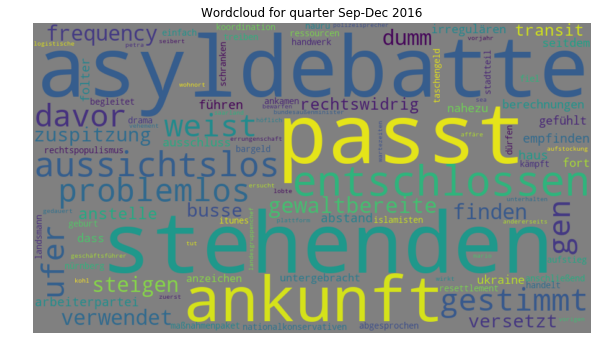

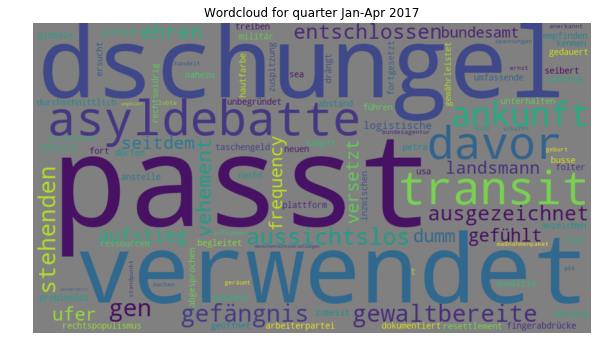

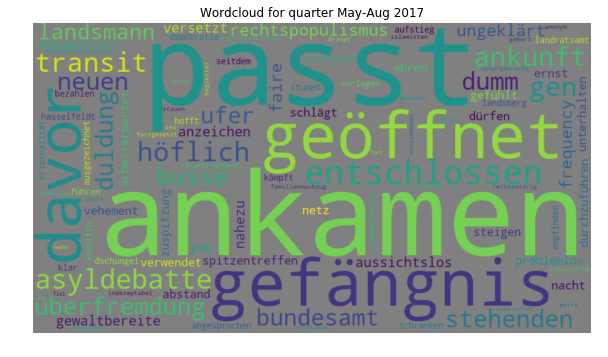

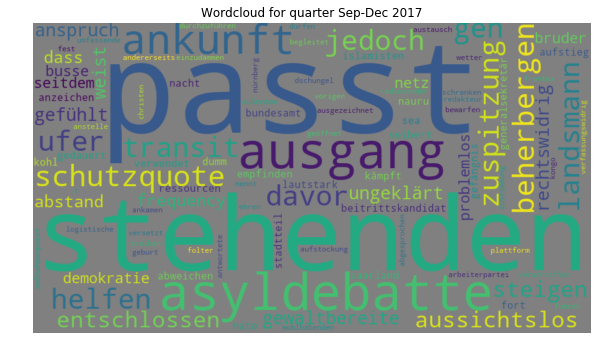

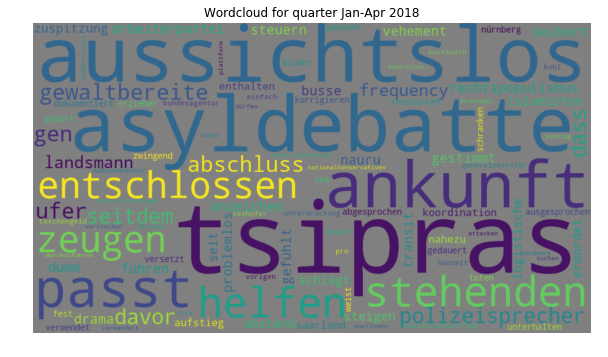

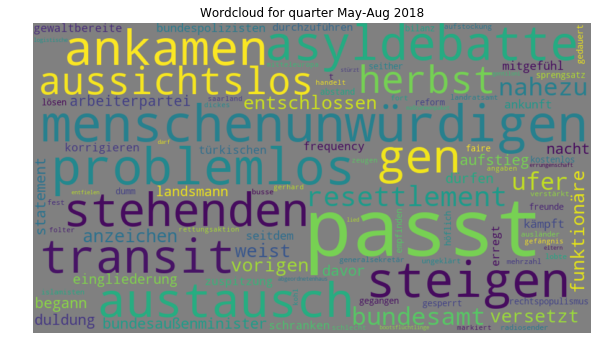

In [11]:
for i, q in enumerate(quarter_label_list):
    visualize_wordcloud(dict_freqs_quarter, q, title[i], relative_scaling=0.3, background_color='grey')